Profit function (Paquette Loss):  
$$\Pi:= \sum_{\textit{weeks with output } 1} 1\cdot(Close-Open)+\sum_{\textit{weeks with output } -1} -1\cdot(Close-Open)= \sum_{\textit{all weeks}} Output_{week}\cdot(Close-Open)$$

In [3]:
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
#sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
#amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [3]:
# Function to add indicators
def calculate_indicators(df, rsi_period=14, cci_period=20, ma_short_period=10, ma_long_period=40, cpc_window=4):

    # Moving Averages with dynamic column names based on periods
    ma_short_column = f'MA{ma_short_period}'
    ma_long_column = f'MA{ma_long_period}'
    normalized_difference_column = f'MA{ma_long_period}_MA{ma_short_period}_difference_normalized'

    # Calculate short and long period moving averages
    df[ma_short_column] = df['Close'].rolling(window=ma_short_period).mean()
    df[ma_long_column] = df['Close'].rolling(window=ma_long_period).mean()

    # Calculate the normalized difference of moving averages
    df[normalized_difference_column] = (df[ma_short_column] - df[ma_long_column]) / df[ma_long_column]

    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(cpc_window).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))
    
    df.drop(columns=[ma_short_column, ma_long_column], inplace=True)
    
    return df

In [4]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    calculate_indicators(df, rsi_period=20, cci_period=20, ma_short_period=10, ma_long_period=40, cpc_window=20)

In [5]:
amzn.head(41)

,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC
0,1997-05-18,0.075000,0.125000,0.075000,0.086460,NaN,NaN,NaN,NaN
1,1997-05-25,0.088021,0.088542,0.065625,0.075000,NaN,NaN,NaN,NaN
2,1997-06-01,0.075521,0.082292,0.072917,0.075000,NaN,NaN,NaN,NaN
3,1997-06-08,0.075521,0.085417,0.068750,0.082815,NaN,NaN,NaN,NaN
4,1997-06-15,0.082812,0.085417,0.076562,0.079170,NaN,NaN,NaN,NaN
5,1997-06-22,0.080208,0.080208,0.074740,0.076305,NaN,NaN,NaN,NaN
6,1997-06-29,0.077083,0.077083,0.073958,0.074480,NaN,NaN,NaN,NaN
7,1997-07-06,0.075521,0.095833,0.073958,0.095575,NaN,NaN,NaN,NaN
8,1997-07-13,0.091667,0.128646,0.091667,0.114585,NaN,NaN,NaN,NaN
9,1997-07-20,0.116146,0.124740,0.105729,0.107815,NaN,NaN,NaN,NaN


In [6]:
# Drop rows with na, depending on parameters chosen for indicators
amzn.drop(index=amzn.index[0:39], inplace=True)
amzn.reset_index(inplace=True)

In [7]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC'],
      dtype='object')

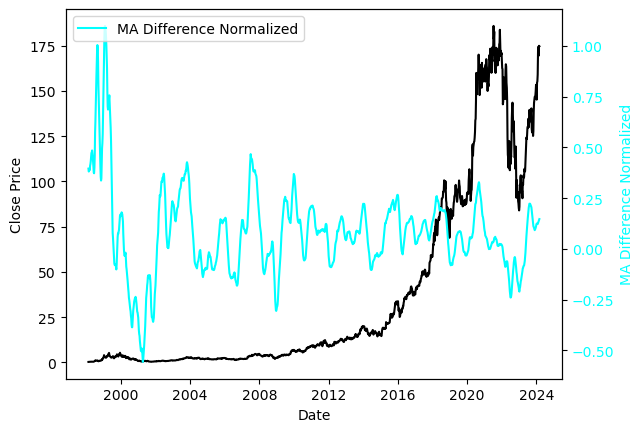

In [8]:
plt.style.use('default')

fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['MA40_MA10_difference_normalized'], color='cyan', label='MA Difference Normalized')
ax2.set_ylabel('MA Difference Normalized', color='cyan')
ax2.tick_params(axis='y', labelcolor='cyan')
ax2.legend(loc='upper left')

plt.show()

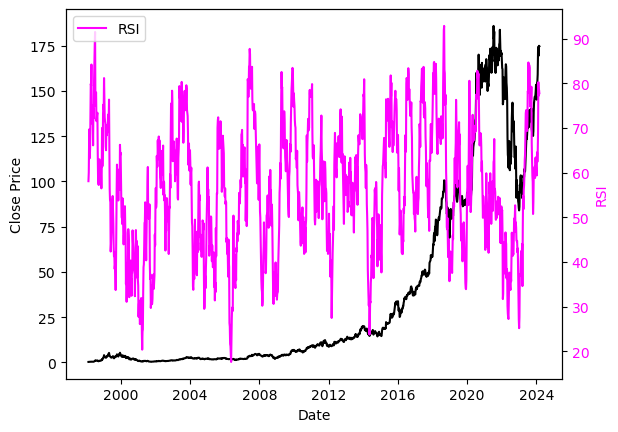

In [9]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='magenta', label='RSI')
ax2.set_ylabel('RSI', color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.legend(loc='upper left')

plt.show()

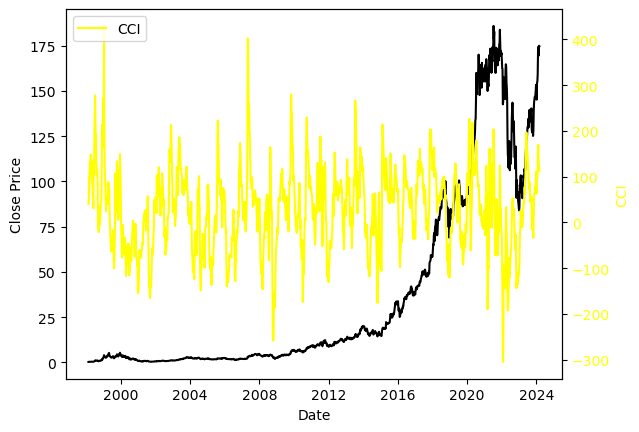

In [10]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='yellow', label='CCI')
ax2.set_ylabel('CCI', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax2.legend(loc='upper left')

plt.show()

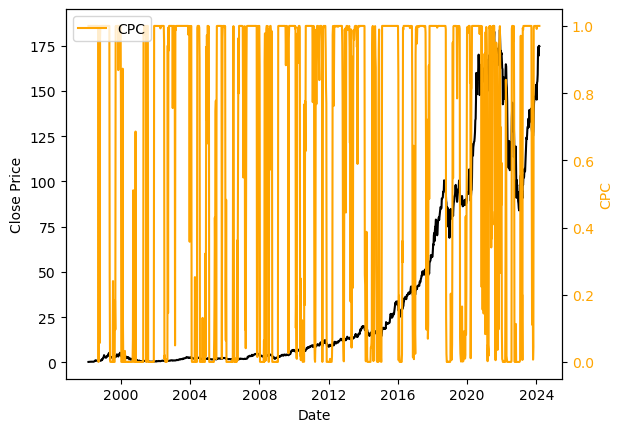

In [11]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='orange', label='CPC')
ax2.set_ylabel('CPC', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper left')

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [5]:
# Calculate the percentage change in closing price from one week to the next
amzn.copy()
amzn.loc[:, 'Current_week_pct_change'] = 100*(amzn['Close'].pct_change(periods=1))
amzn.loc[:, 'Next_week_pct_change'] = 100*(amzn['Close'].pct_change(periods=1).shift(-1))

# Define a threshold for what we consider to be a flat week, e.g. 1% price change
# Define a function to categorize the change as +1, 0, or -1
def categorize_change(weekly_return, flat_threshold=1):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

# Apply the function to the percentage change column to create the target variable
amzn.loc[:, 'Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)
amzn.loc[:, 'Log_return'] = np.log(amzn['Close'].shift(-1) / amzn['Close'])

# Drop the last row as it contains NaN in the 'Next_week_pct_change' column
amzn = amzn[1:-1]

In [13]:
amzn

,index,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC,Current_week_pct_change,Next_week_pct_change,Next_week_market_behavior,Log_return
1,40,1998-02-22,0.260937,0.264583,0.252604,0.263545,0.381240,60.049318,43.527506,1.000000,1.607711,21.738223,1,0.196703
2,41,1998-03-01,0.264583,0.331771,0.260417,0.320835,0.387294,67.286021,98.693459,1.000000,21.738223,-0.324154,0,-0.003247
3,42,1998-03-08,0.316146,0.328125,0.291667,0.319795,0.392028,69.732663,100.946250,1.000000,-0.324154,2.523492,1,0.024922
4,43,1998-03-15,0.320312,0.367708,0.319792,0.327865,0.389265,63.242467,128.911091,1.000000,2.523492,6.751254,1,0.065331
5,44,1998-03-22,0.331510,0.364583,0.324479,0.350000,0.410742,65.539664,132.953136,1.000000,6.751254,1.191429,1,0.011844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1393,2024-01-28,156.890000,160.720000,153.900000,159.120000,0.122564,64.302342,117.881785,0.999997,2.433372,7.975113,1,0.076731
1355,1394,2024-02-04,159.340000,172.500000,154.810000,171.810000,0.127295,68.800862,162.285928,1.000000,7.975113,1.536581,1,0.015249
1356,1395,2024-02-11,170.200000,175.000000,167.650000,174.450000,0.133117,80.248232,169.431959,1.000000,1.536581,-2.831757,-1,-0.028726
1357,1396,2024-02-18,174.800000,175.390000,165.750000,169.510000,0.136922,77.218441,130.653961,1.000000,-2.831757,3.232848,1,0.031817


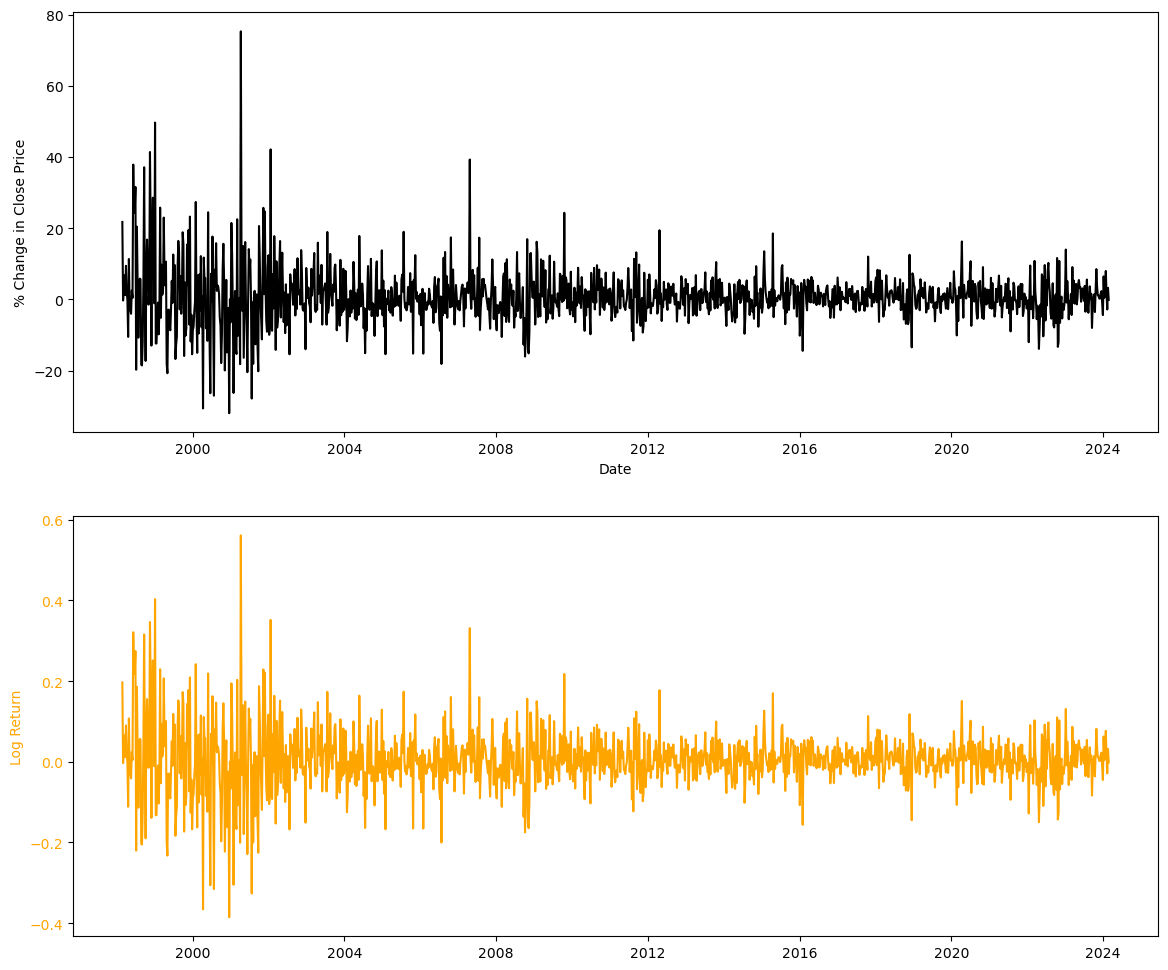

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 12))
axes[0].plot(amzn['Date'], amzn['Next_week_pct_change'], color='Black', label='% change')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('% Change in Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

axes[1].plot(amzn['Date'], amzn['Log_return'], color='orange', label='Log Return')
axes[1].set_ylabel('Log Return', color='orange')
axes[1].tick_params(axis='y', labelcolor='orange')

Text(0, 0.5, '% Change in Close Price')

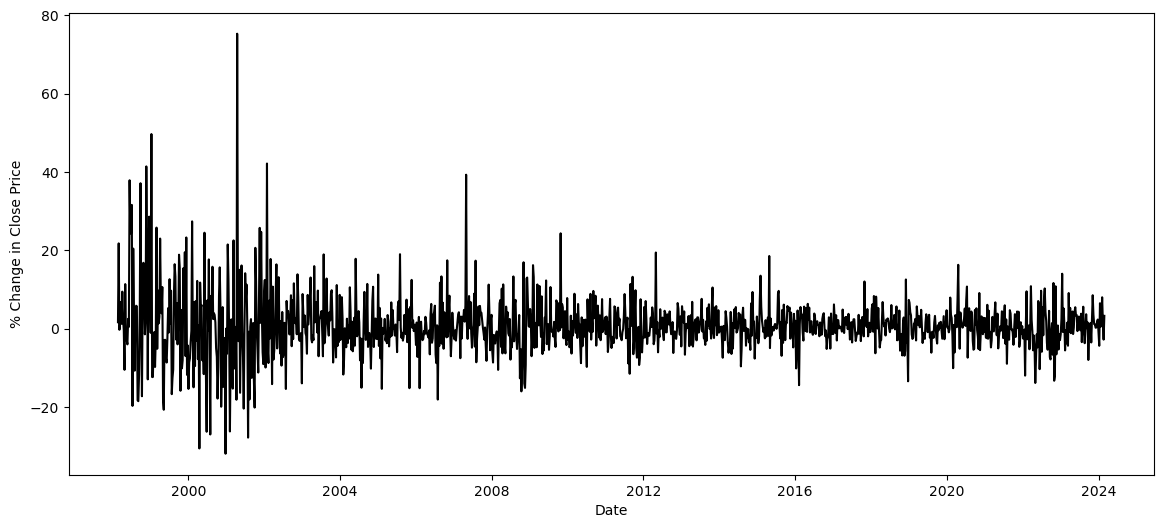

In [15]:
fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(amzn['Date'], amzn['Current_week_pct_change'], color='Black', label='% change')
axes.set_xlabel('Date')
axes.set_ylabel('% Change in Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

In [16]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC',
       'Current_week_pct_change', 'Next_week_pct_change',
       'Next_week_market_behavior', 'Log_return'],
      dtype='object')

In [17]:
# Define your feature columns
feature_columns = ['MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC', 'Current_week_pct_change']

# Now let's prepare the features
features = amzn[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
print(features)

# Prepare the target to fit the labeling {0,1,2}
target = amzn['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

[[0.56655896 0.56402474 0.47434204 0.99999986 0.31309369]
 [0.57021236 0.66030135 0.54945408 1.         0.50081522]
 [0.57306934 0.69285132 0.5525214  1.         0.29507861]
 ...
 [0.41681838 0.83274975 0.64576917 1.         0.31243038]
 [0.41911454 0.79244161 0.59297039 0.99999989 0.27169465]
 [0.42267952 0.80948575 0.57745426 0.99999999 0.32824845]]


In [18]:
# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('MADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

#coeff_shape = torch.Size([model.num_rules, model.num_classes, model.num_in+1])

# Initialize the consequent parameters and set them to small (10^-2) random values using the coeff property setter
#model.coeff = torch.randn(coeff_shape, dtype=torch.float) * 1

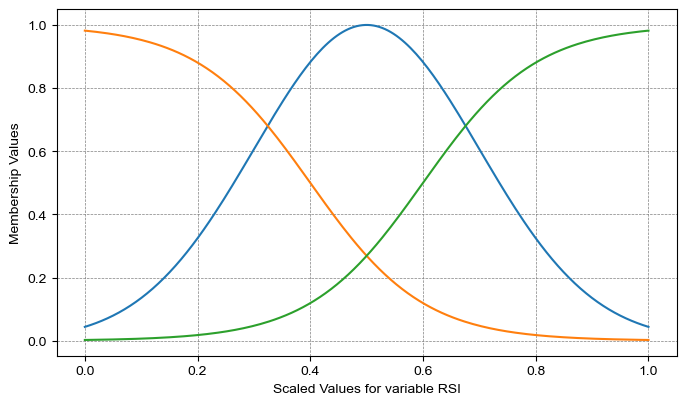

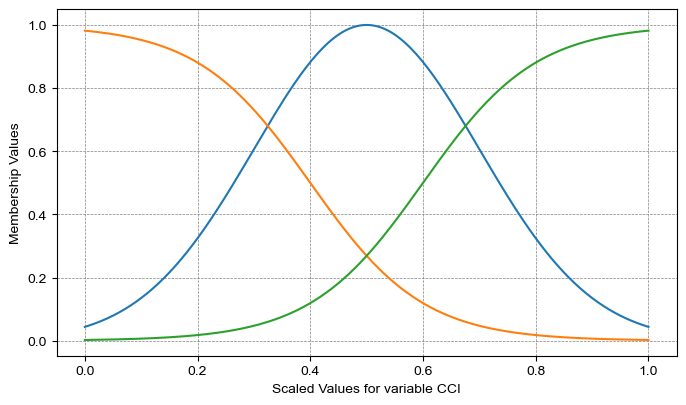

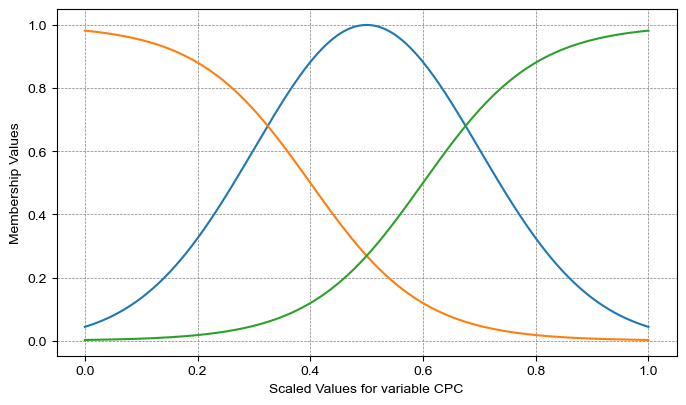

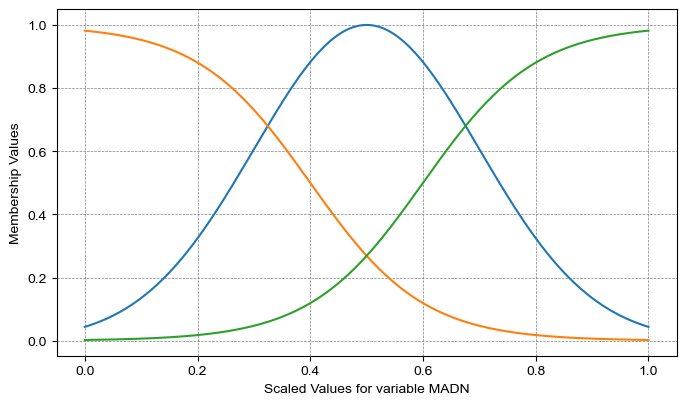

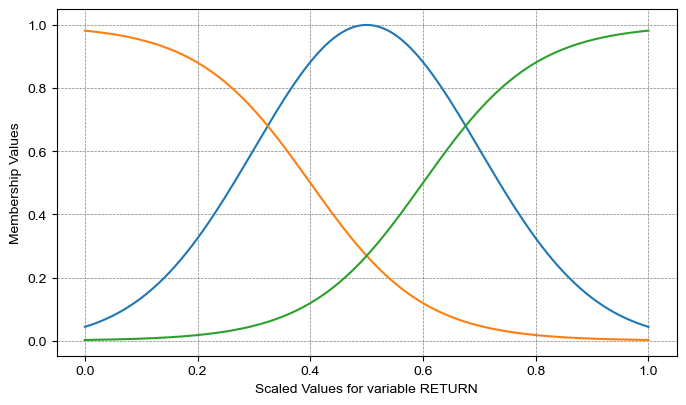

In [19]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [43]:
model.coeff

Parameter containing:
tensor([[[-1.5555e-02,  8.5713e-02, -1.0580e-01,  8.9446e-02,  6.4813e-02],
         [ 9.5549e-02, -1.4927e-01, -2.1365e-02,  2.4274e-03, -3.5262e-02],
         [ 6.4006e-02,  1.1651e-01, -1.5422e-01, -4.2467e-02,  2.3360e-02]],

        [[-7.9440e-05, -5.0788e-03,  9.9014e-02, -4.3420e-02,  1.5180e-02],
         [ 1.4090e-01, -9.1384e-02, -1.1512e-01,  2.3143e-02,  1.0861e-01],
         [-1.6194e-01,  6.0998e-02, -2.2062e-02,  1.1097e-01, -1.7496e-01]],

        [[ 5.4954e-02, -4.5626e-02,  8.1677e-02, -9.5539e-02, -1.9423e-02],
         [-5.1912e-02, -6.9241e-02, -1.2134e-01, -2.4191e-01,  1.1475e-01],
         [ 1.7706e-01, -8.1333e-02, -1.8683e-02,  8.5862e-02, -5.0713e-02]],

        ...,

        [[ 1.3504e-02, -3.2391e-01,  1.5734e-01,  9.5601e-02, -2.0470e-02],
         [ 7.2277e-02,  1.0751e-01,  5.0359e-02,  9.0447e-02, -1.1615e-01],
         [ 1.7154e-01,  4.4662e-03,  1.3736e-01,  2.3228e-02, -2.6755e-02]],

        [[ 3.6507e-02, -1.0710e-01, -7.8277e

In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
experimental.train_anfis_classifier_with(model=model, data=train_loader, optimizer=optimizer, epochs=300, show_plots=True)

### Training for 300 epochs, training size = 1080 cases
epoch    0: Loss=1.00314
epoch   10: Loss=1.00157
epoch   20: Loss=1.00156
epoch   30: Loss=1.00171
epoch   40: Loss=1.00181
epoch   50: Loss=1.00187
epoch   60: Loss=1.00201
epoch   70: Loss=1.00212
epoch   80: Loss=1.00216
epoch   90: Loss=1.00224
epoch  100: Loss=1.00246
epoch  110: Loss=1.00237
epoch  120: Loss=1.00240
epoch  130: Loss=1.00241
epoch  140: Loss=1.00233
epoch  150: Loss=1.00226
epoch  160: Loss=1.00214
epoch  170: Loss=1.00216
epoch  180: Loss=1.00223


KeyboardInterrupt: 

In [18]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
predict_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels=experimental.classification_predictions(model, predict_loader)

NameError: name 'X_train' is not defined

In [90]:
actual_labels=y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print('Confusion Matrix:\n', conf_matrix)

# Classification Report
class_report = classification_report(actual_labels, predicted_labels)
print('Classification Report:\n', class_report)

Accuracy: 0.50
Confusion Matrix:
 [[241  23 160]
 [ 71  24  80]
 [189  17 275]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.57      0.52       424
           0       0.38      0.14      0.20       175
           1       0.53      0.57      0.55       481

    accuracy                           0.50      1080
   macro avg       0.46      0.43      0.42      1080
weighted avg       0.49      0.50      0.48      1080



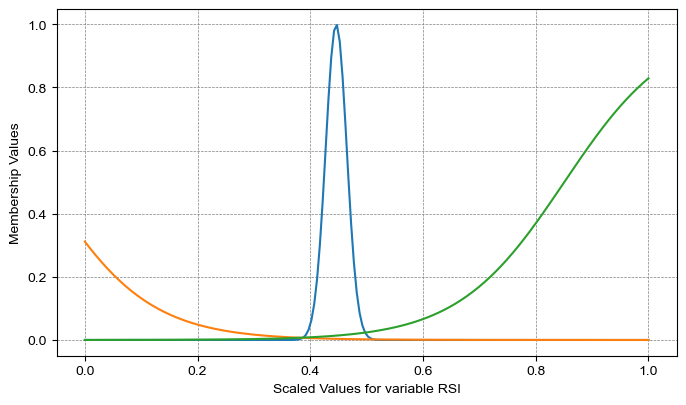

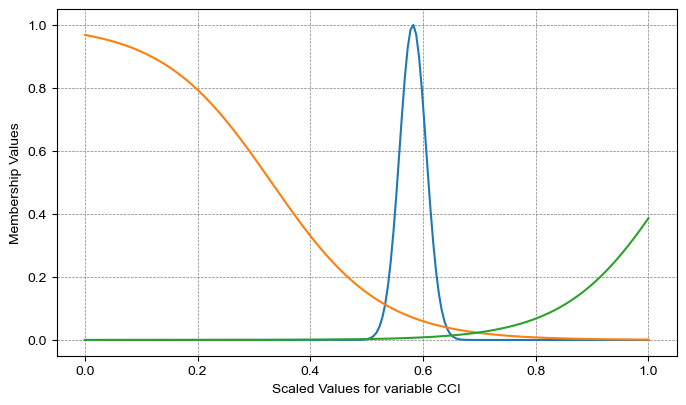

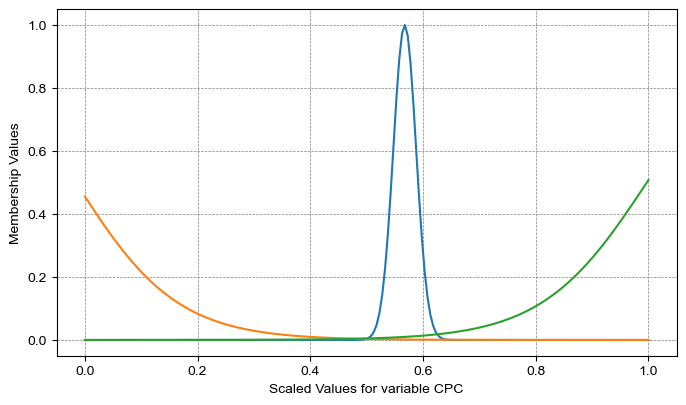

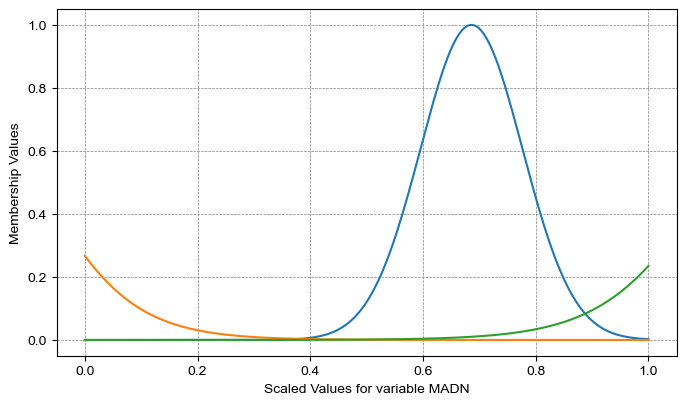

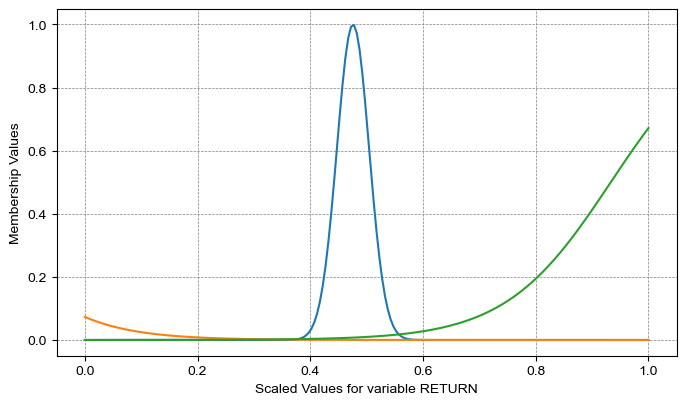

In [91]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [6]:
regression_data=pd.DataFrame()
regression_target=pd.DataFrame()

regression_data['xtp6']=amzn['Current_week_pct_change'].shift(-6)
regression_data['xt']=amzn['Current_week_pct_change']
regression_data['xtm6']=amzn['Current_week_pct_change'].shift(6)
regression_data['xtm12']=amzn['Current_week_pct_change'].shift(12)
regression_data['xtm18']=amzn['Current_week_pct_change'].shift(18)

regression_data.dropna(inplace=True)

regression_target['xtp6']=regression_data['xtp6']
regression_data.drop(columns=['xtp6'], inplace=True)

scaler=MinMaxScaler()

regression_data=scaler.fit_transform(regression_data)
regression_target=scaler.fit_transform(regression_target)

print(regression_data)
print(regression_target)

[[0.34978356 0.22603714 0.56222011 0.17449852]
 [0.26430708 0.30268774 0.48358142 0.29810142]
 [0.27148911 0.39183638 0.24300541 0.39527026]
 ...
 [0.28910564 0.30862445 0.30426346 0.29838142]
 [0.25698058 0.30812164 0.31143775 0.33211057]
 [0.35832629 0.29994435 0.26490739 0.29884409]]
[[0.18726418]
 [0.2330422 ]
 [0.3703676 ]
 ...
 [0.31243038]
 [0.27169465]
 [0.32824845]]


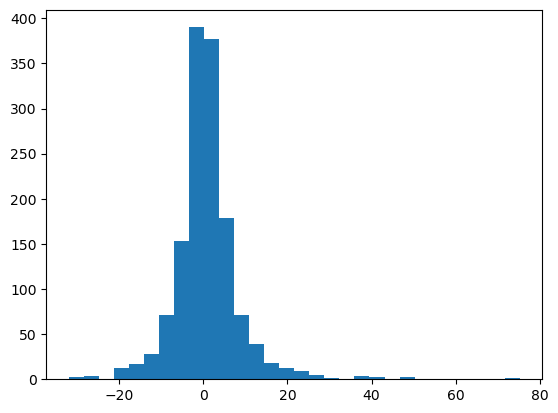

In [7]:
plt.hist(amzn['Current_week_pct_change'], bins=30)
plt.show()

In [8]:
amzn['Current_week_pct_change'].describe()

count    1397.000000
mean        0.832673
std         7.781058
min       -31.967213
25%        -2.644136
50%         0.358151
75%         3.653846
max        75.268817
Name: Current_week_pct_change, dtype: float64

In [9]:
invardefs = [
            ('xtm18', membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xtm12', membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xtm6',  membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xt',    membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ]
outvars = ['xtp6']
regression_model = anfis.AnfisNet('Time series regression', invardefs, outvars, hybrid=True)

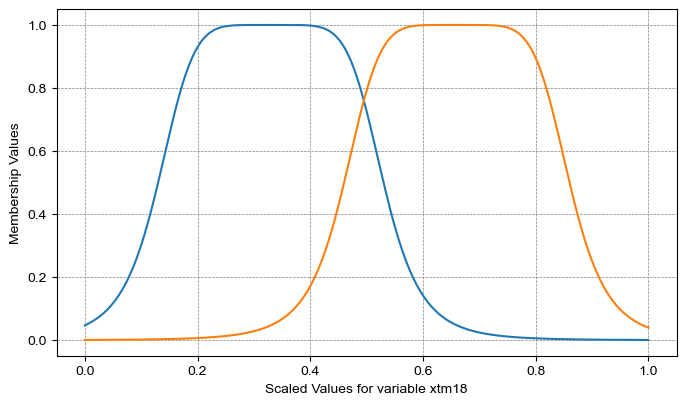

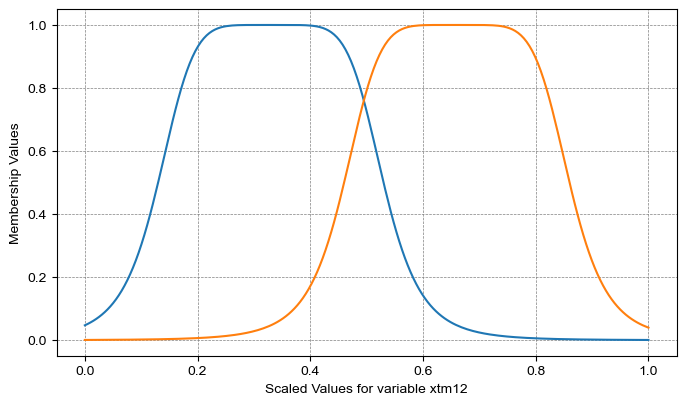

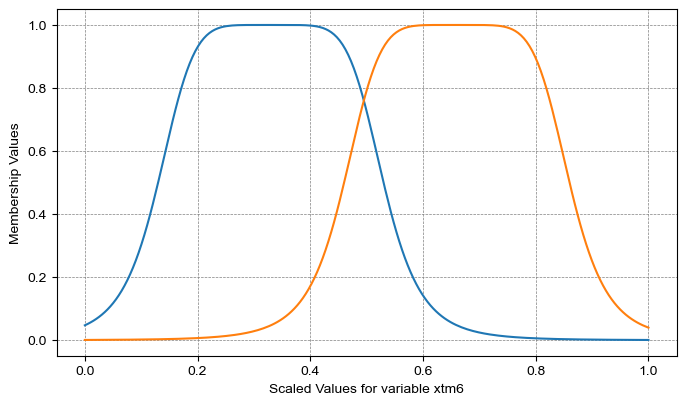

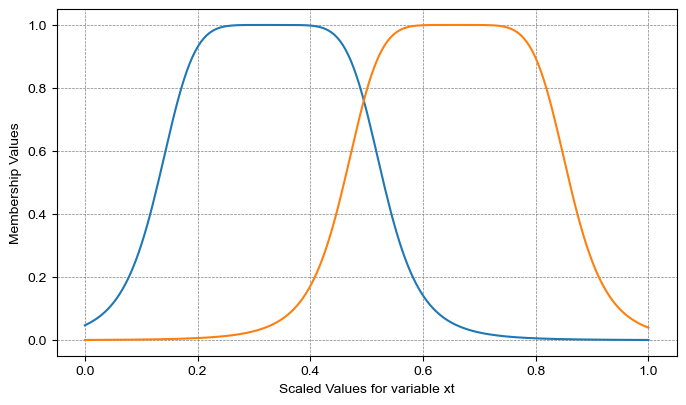

In [31]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(regression_model, x)

In [10]:
# Calculate the index for the split
split_idx = int(len(regression_data) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = regression_data[:split_idx]
X_test = regression_data[split_idx:]
y_train = regression_target[:split_idx]
y_test = regression_target[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
experimental.train_anfis(regression_model, train_loader, 500, show_plots=True)

### Training for 500 epochs, training size = 1098 cases


AssertionError: Coeff shape should be torch.Size([16, 1, 5]), but is actually torch.Size([16, 80, 5])

In [18]:
import sys
import itertools
import numpy as np

sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')

import torch
from torch.utils.data import TensorDataset, DataLoader

import anfis
from membership import BellMembFunc, make_bell_mfs
from experimental import train_anfis, test_anfis

dtype = torch.float


def ex4_model():
    '''
        Example 4 model, from Jang's data; 4 variables with 2 MFs each.
        Predict x(t+6) based on x(t-18), x(t-12), x(t-6), x(t)
        These are the starting MFs values he suggests.
    '''
    invardefs = [
            ('xm18', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('xm12', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('xm6',  make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('x',    make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ]
    outvars = ['xp6']
    model = anfis.AnfisNet('Jang\'s example 4', invardefs, outvars)
    return model


def jang_ex4_trained_model():
    '''
        Example 4 model, from Jang's data; 4 variables with 2 MFs each.
        These are the final 'trained' values from pg. 683.
    '''
    # Data from Table VI:
    mfs = [
        (0.1790, 2.0456, 0.4798),  # SMALL1
        (0.1584, 2.0103, 1.4975),  # LARGE1
        (0.2410, 1.9533, 0.2960),  # SMALL2
        (0.2923, 1.9178, 1.7824),  # LARGE2
        (0.3798, 2.1490, 0.6599),  # SMALL3
        (0.4884, 1.8967, 1.6465),  # LARGE3
        (0.2815, 2.0170, 0.3341),  # SMALL4
        (0.1616, 2.0165, 1.4727),  # LARGE4
    ]
    invardefs = [
            ('xm18', [BellMembFunc(*mfs[0]), BellMembFunc(*mfs[1])]),
            ('xm12', [BellMembFunc(*mfs[2]), BellMembFunc(*mfs[3])]),
            ('xm6',  [BellMembFunc(*mfs[4]), BellMembFunc(*mfs[5])]),
            ('x',    [BellMembFunc(*mfs[6]), BellMembFunc(*mfs[7])]),
            ]
    outvars = ['xp6']
    model = anfis.AnfisNet('Jang\'s example 4 (trained)', invardefs, outvars)
    # Jang calls this "the parameter matrix C" on pg 683:
    coeff = torch.tensor([
        [0.2167,   0.7233, -0.0365,  0.5433,  0.0276],
        [0.2141,   0.5704, -0.4826,  1.2452, -0.3778],
        [-0.0683,  0.0022,  0.6495,  2.7320, -2.2916],
        [-0.2616,  0.9190, -2.9931,  1.9467,  1.6555],
        [-0.3293, -0.8943,  1.4290, -1.6550,  2.3735],
        [2.5820,  -2.3109,  3.7925, -5.8068,  4.0478],
        [0.8797,  -0.9407,  2.2487,  0.7759, -2.0714],
        [-0.8417, -1.5394, -1.5329,  2.2834,  2.4140],
        [-0.6422, -0.4384,  0.9792, -0.3993,  1.5593],
        [1.5534,  -0.0542, -4.7256,  0.7244,  2.7350],
        [-0.6864, -2.2435,  0.1585,  0.5304,  3.5411],
        [-0.3190, -1.3160,  0.9689,  1.4887,  0.7079],
        [-0.3200, -0.4654,  0.4880, -0.0559,  0.9622],
        [4.0220,  -3.8886,  1.0547, -0.7427, -0.4464],
        [0.3338,  -0.3306, -0.5961,  1.1220,  0.3529],
        [-0.5572,  0.9190, -0.8745,  2.1899, -0.9497],
    ])
    model.coeff = coeff.unsqueeze(1)  # add extra dim for output vars
    return model


def jang_ex4_data(filename):
    '''
        Read Jang's data for the MG function to be modelled.
    '''
    num_cases = 500
    x = torch.zeros((num_cases, 4))
    y = torch.zeros((num_cases, 1))
    with open(filename, 'r') as fh:
        for i, line in enumerate(fh):
            values = [float(v) for v in line.strip().split()]
            x[i] = torch.tensor(values[0:4])
            y[i] = values[4]
    dl = DataLoader(TensorDataset(x, y), batch_size=1024, shuffle=True)
    return dl

show_plots = True
model = ex4_model()
train_data = jang_ex4_data('jang-example4-data.trn')
train_anfis(model, train_data, 500, show_plots)
test_data = jang_ex4_data('jang-example4-data.chk')
test_anfis(model, test_data, show_plots)
'''
model = jang_ex4_trained_model()
test_data = jang_ex4_data('jang-example4-data.trn')
test_anfis(model, test_data, show_plots)
test_data = jang_ex4_data('jang-example4-data.chk')
test_anfis(model, test_data, show_plots)
'''

### Training for 500 epochs, training size = 500 cases


AssertionError: Coeff shape should be torch.Size([16, 1, 5]), but is actually torch.Size([16, 80, 5])